In [1]:
from pySPM import Bruker
from scipy import ndimage
from pint import UnitRegistry
import numpy as np
from matplotlib import pyplot as plt
import tqdm
import json



import torch.nn
from torchvision import transforms as transforms
#from glob import glob
from tqdm import notebook
import pickle
import random
import numpy as np
# what I need for the MoS2 processing
from pySPM import Bruker
import tqdm
from pint import UnitRegistry
import cv2

from pySPM import Bruker
from scipy import ndimage
from pint import UnitRegistry
import numpy as np
from matplotlib import pyplot as plt
import tqdm
import json
import os
import glob
import pandas as pd
from collections import Counter

def poly_flatten(data, deg, axis=0):
    
    fitted_data = np.zeros_like(data)
    
    major_axis = axis
    minor_axis = int(~bool(major_axis))

    xpos = np.arange(data.shape[minor_axis])
    pbar = tqdm.tqdm(np.arange(data.shape[major_axis]))
    for i in pbar:
        if major_axis == 0:
            this_line = data[i, :]
        else:
            this_line = data[:, i]
        coef = np.polyfit(xpos, this_line, deg)
        offs = np.polyval(coef, xpos)
        if major_axis == 0:
            fitted_data[i, :] = this_line - offs
        else:
            fitted_data[:, i] = this_line - offs

    return fitted_data


def read_and_plot_spm(filename):

    spm = Bruker(filename)
    img = spm.get_channel('Height Sensor')
    img = img.correct_plane().corr_fit2d().filter_scars_removal(inline=False)

    data = np.array(img.pixels.copy())
    data = poly_flatten(data, deg=2)            # leveling
    data = ndimage.median_filter(data, size=2)  # median filter
    data = np.array(data) - np.mean(data)       # zero-average

    ureg = UnitRegistry()
    Q_ = ureg.Quantity

    # compute real dimensions with pint
    base_unit = 'nm'
    pix, _ = [Q_(*it).to(base_unit).magnitude for it in img.pxs()]
    xdim = pix * img.size['pixels']['x']
    ydim = pix * img.size['pixels']['y']  # looks like the metadata is wrong about y scale?
    zdim = Q_(1, img.zscale).to(base_unit).magnitude

    # plot image with some estimate for bounds
    fig, ax = plt.subplots(figsize=(16, 8))
    im = ax.imshow(np.flipud(data), 'bone',
                vmin=np.percentile(data, 0.5), vmax=np.percentile(data, 99.5),
                extent=[0, xdim, 0, ydim])
    
    ax.set_xlabel(f'x ({base_unit})')  # label axis with units
    ax.set_ylabel(f'y ({base_unit})')
    
    cb = plt.colorbar(im)
    cb.set_label( base_unit )  # label colorbar with units

    return fig


class SPMRecord(object):

    def __init__(self, filename, channel='Height Sensor', base_unit='nm'):
        suffix = filename.split('.')[-1]
        if suffix == 'json':
            self.load(filename)
            return
        elif suffix != 'spm':
            raise ValueError('Expected json or spm file.')

        spm = Bruker(filename)
        img = spm.get_channel(channel)
        img = img.correct_plane().corr_fit2d().filter_scars_removal(inline=False)

        # compute real dimensions with pint
        ureg = UnitRegistry()
        Q_ = ureg.Quantity
        
        self.base_unit = base_unit
        pix, _ = [Q_(*it).to(self.base_unit).magnitude for it in img.pxs()]
        self.xdim = pix * img.size['pixels']['x']
        self.ydim = pix * img.size['pixels']['y']  # looks like the metadata is wrong about y scale?
        self.zdim = Q_(1, img.zscale).to(self.base_unit).magnitude

        # retain raw data from spm
        data = np.array(img.pixels.copy())

        # level the image using preset filters
        data = poly_flatten(data, deg=2)            # leveling
        data = ndimage.median_filter(data, size=2)  # median filter
        data = np.array(data) - np.mean(data)       # zero-average

        self.data = data

    def plot(self):
        # plot image with some estimate for bounds
        fig, ax = plt.subplots(figsize=(16, 8))
        im = ax.imshow(np.flipud(self.data), 'bone',
                    vmin=np.percentile(self.data, 0.5), 
                    vmax=np.percentile(self.data, 99.5),
                    extent=[0, self.xdim, 0, self.ydim])
        
        ax.set_xlabel(f'x ({self.base_unit})')  # label axis with units
        ax.set_ylabel(f'y ({self.base_unit})')
        
        cb = plt.colorbar(im)
        cb.set_label( self.base_unit )  # label colorbar with units

        return fig

    def save(self, filename):
        buffer = {}
        buffer['dimensions'] = {'base_unit': self.base_unit, 'z': self.zdim,
                                'y': self.ydim, 'x': self.xdim}
        buffer['data'] = self.data.round(3).tolist()

        with open(filename, 'w') as fid:
            json.dump(buffer, fid)

        return

    def load(self, filename):
        with open(filename, 'r') as fid:
            buffer = json.load(fid)

        self.data = np.array(buffer['data'])

        dims = buffer['dimensions']
        self.base_unit = dims['base_unit']
        self.xdim = dims['x']
        self.ydim = dims['y']
        self.zdim = dims['z']

        return

# Combining Targets and Image Files
this separation made the separate data to be more than the instances in the combined data (347)

In [2]:
drive_prefix ='../MoS2_HeightCenter1um_spm_with_Activities/'

all_files = glob.glob(os.path.join( drive_prefix, '*.spm'))
print(f'found {len(all_files)} tif files in Drive')



sampleId_img = []
for index, item in enumerate(all_files):
    
    filename = item.split('/')[-1]
    sampleLabel = filename.split('_')[0]
    sampleId = int(filename.split('_')[1])
    sampleId_img.append(sampleId)

print('sampleId_img: ', len(sampleId_img))
        


df = pd.read_csv('../MoS2_activities_substrate.csv')

print(df.keys())
sampleLabel = df['sampleLabel'].tolist()
sampleId_target = df['sampleId'].tolist()
Temperature = df['T'].tolist()
Substrate = df['substrate'].tolist()
Time = df['time'].tolist()

unique_sampleId = []
test_Id = [10190, 10308, 10361, 10782, 10906, 11048, 11280, 11733, 12883, 13070, 13377, 16937, 13424, 13506, 13933, 13944, 16157, 14596, 14615, 14672, 14702, 14736, 14746, 14777, 14954, 16168, 16181]
spm_files_and_targets = []
for index, Id in enumerate(sampleId_target):
    dicts = {}
    for index2, Id2 in enumerate(sampleId_img):
        if Id not in unique_sampleId and Id not in test_Id and Id==Id2:
            if ~np.isnan(Temperature[index]) and Temperature[index] !=600:
                unique_sampleId.append(Id)
                dicts['sampleId'] = Id
                dicts['sampleLabel'] = sampleLabel[index]
                dicts['T'] = Temperature[index]
                dicts['time'] = Time[index]
                dicts['substrate'] = Substrate[index]
                dicts['image_file'] = all_files[index]
                
                spm_files_and_targets.append(dicts)
                break


print(len(spm_files_and_targets))

df_Temp = pd.DataFrame(spm_files_and_targets)
Temp = [item for item in df_Temp['T']]
print(Counter(Temp))

found 368 tif files in Drive
sampleId_img:  368
Index(['Unnamed: 0', 'sampleLabel', 'sampleId', 'time', 'T', 'P', 'substrate'], dtype='object')
235
Counter({950.0: 117, 1000.0: 92, 900.0: 26})


# Random Cropping to Ensure a Balanced Data (Temp)

100%|███████████████████████████████████████| 512/512 [00:00<00:00, 5254.62it/s]


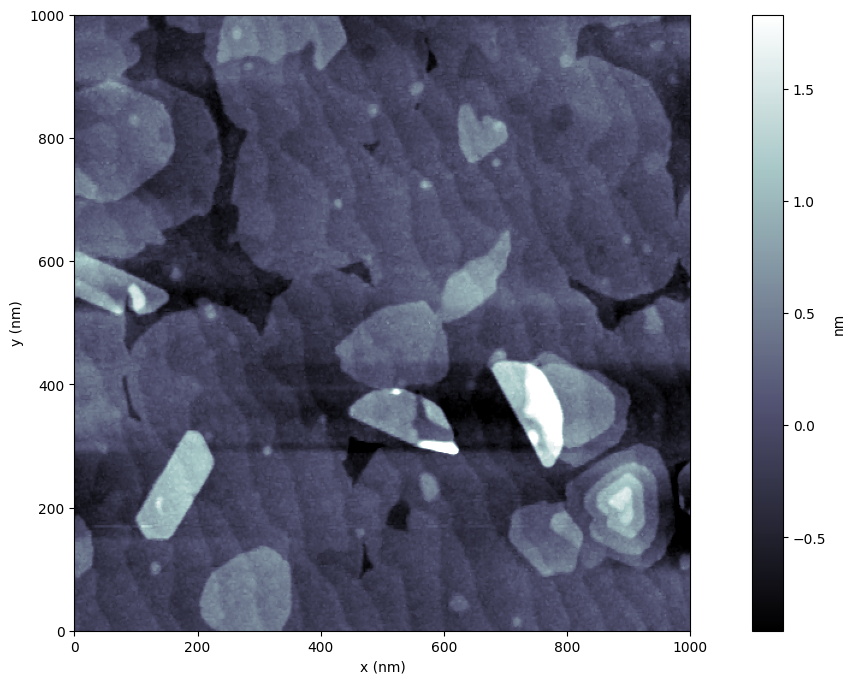

In [3]:
import glob
item = all_files[0]
spm = SPMRecord(item)
_ = spm.plot()

In [3]:
# Substrate Data sEt

def cropped_image_temp(spm_files_and_targets):
    df = pd.DataFrame(spm_files_and_targets)
    sampleId = df['sampleId'].tolist()
    sampleLabel = df['sampleLabel'].tolist()
    T = df['T'].tolist()
    time = df['time'].tolist()
    substrate = df['substrate'].tolist()
    image_files = df['image_file'].tolist()
    
    
    bad_index = []
    IMG_SIZE = 224
    num_crop = 0
    count_1000 = 0
    MoS2_Analysis_Cropped_data = []
    
    for index, item in enumerate(image_files):
        filename = item.split('/')[-1]
        #sampleLabel = filename.split('_')[0]
        #sampleId = filename.split('_')[1]

        dicts = {}

        if T[index] == 900.0:
            num_crop = 9
        elif T[index] == 950.0:
            num_crop = 2
        elif T[index] == 1000.0:
            if count_1000 < 37:
                num_crop = 2
                count_1000 += 1
            else:
                num_crop = 3

        for _ in range(num_crop):

            try:

                spm = Bruker(item)
                img1 = spm.get_channel('Height Sensor').correct_plane().corr_fit2d().filter_scars_removal(inline=False)
                deg = 2
                data = np.array(img1.pixels.copy())
                fitted_data = np.zeros_like(data)
                for major_axis in [0]:
                    minor_axis = int(~bool(major_axis))
                    xpos = np.arange(data.shape[minor_axis])
                    pbar = tqdm.tqdm(np.arange(data.shape[major_axis]))
                    for i in pbar:
                        if major_axis == 0:
                            this_line = data[i, :]
                        else:
                            this_line = data[:, i]
                        coef = np.polyfit(xpos, this_line, deg)
                        offs = np.polyval(coef, xpos)
                        if major_axis == 0:
                            fitted_data[i, :] = this_line - offs
                        else:
                            fitted_data[:, i] = this_line - offs
                    data = np.array(fitted_data)

                data = np.array(data) - np.mean(data)  # zero-average

                filtered_data = ndimage.median_filter(data, size=2)

                low, high = np.percentile(filtered_data, [0.5, 99.5])
                AFM_Images = np.clip(filtered_data, low, high)
                AFM_Images -= AFM_Images.min()
                AFM_Images = AFM_Images / AFM_Images.max() * 255

                image_tensor = torch.tensor(AFM_Images, dtype=torch.float32)

                cropper = transforms.RandomCrop(size=(IMG_SIZE, IMG_SIZE), pad_if_needed=True)
                image = cropper(image_tensor).numpy()
                #print(image.shape)
                dicts['sampleId'] = sampleId[index]
                dicts['sampleLabel'] = sampleLabel[index]
                dicts['image_sno'] = index
                dicts['T'] = T[index]
                dicts['substrate'] = substrate[index]
                dicts['time'] = time[index]
                dicts['image']= image
                MoS2_Analysis_Cropped_data.append(dicts)

            except:
                bad_index.append(index)
                continue
                
    return MoS2_Analysis_Cropped_data, bad_index
MoS2_Analysis_Cropped_data, bad_index = cropped_image_temp(spm_files_and_targets)

100%|███████████████████████████████████████| 512/512 [00:00<00:00, 6530.08it/s]


In [4]:
print(len(MoS2_Analysis_Cropped_data))
print(len(bad_index))
df = pd.DataFrame(MoS2_Analysis_Cropped_data)
temp = df['T'].tolist()
print(Counter(temp))

699
8
Counter({900.0: 234, 1000.0: 233, 950.0: 232})


In [5]:
df_Temp = pd.DataFrame(MoS2_Analysis_Cropped_data)
Temp = df_Temp['T'].tolist()
print(Counter(Temp))
print(Counter(bad_index))

with open("Data/MoS2_Analysis_Cropped_Data", "wb") as fp:   #Pickling
  pickle.dump(MoS2_Analysis_Cropped_data, fp) 

Counter({900.0: 234, 1000.0: 233, 950.0: 232})
Counter({199: 3, 220: 3, 33: 2})


# After Here is NOT Used

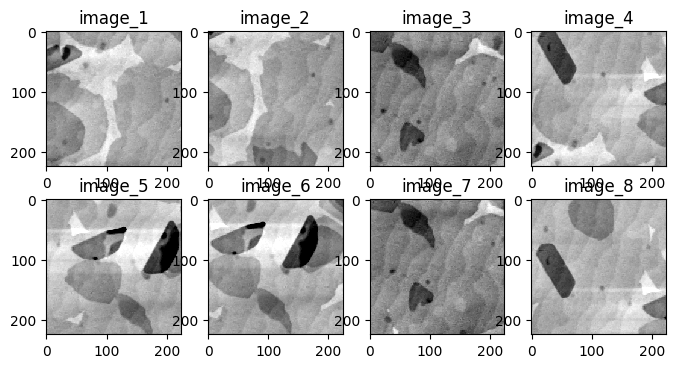

In [7]:
all_img= MoS2_spmImage_ids['image']#[:1000]

fig = plt.figure(figsize=(8, 4))  # width, height in inches

for i in range(0, 8):
    #sub = fig.add_subplot(64, 1, i + 1)
    sub = fig.add_subplot(2, 4, i + 1)
    sub.imshow(all_img[i], interpolation='nearest',cmap='binary')
    sub.set_title(f'image_{i+1}')